<a href="https://colab.research.google.com/github/jhu-nanoenergy/DTIRC/blob/main/AE_framework_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Helpful tutorial / example links
# https://github.com/timbmg/VAE-CVAE-MNIST/blob/master/models.py
# https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

In [2]:
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.stats as stat
import pandas as pd
import numpy as np
import os
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchvision
import torch.optim as optim
import argparse
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint 
import h5py

import gc

!pip install -q -U torchinfo
from torchinfo import summary

plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)


Mounted at /content/drive/


In [4]:
# hyperparameters
full_data_num = 500 #amount of data to use from EACH int / ext dataset


latent_features = 16
epochs = 10
lr = 0.05

spec_points = 219
num_segments = 2

# for defining network
fv = [256, 256, 512, 1024, 2048] #Channels/Convolutions of Images
ks = 3 #kernel size
feat_size = 512 #Feature Space Size
mv_size = 20 #Latent space sampling size (mean and variance)

In [5]:


# Get all data from drive
int_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/int_total_sqr_no_struct.mat', squeeze_me=True)
# ext_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/ext_total_sqr_no_struct.mat', squeeze_me=True)
wavelengths = int_data_all['lambda']
wavelengths = np.delete(wavelengths,np.where(wavelengths==[0.5]))
wavelengths = np.delete(wavelengths,np.where(wavelengths==[1]))
wavelengths = np.transpose(np.tile(wavelengths,(3,1)))

In [6]:
print(np.shape(wavelengths))

(219, 3)


In [7]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
fname_mask = '/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/allData.h5'

hdf_file = h5py.File(fname_mask, "r")
print(list(hdf_file.keys()))

# dext = hdf_file['ext']
dext_spectra = hdf_file['ext/maskCell']
dint_spectra = hdf_file['int/maskCell']
combined = np.concatenate((dext_spectra[:11],dint_spectra[:11]), axis=0)
# print(dext.keys())
print(np.shape(combined))

['ext', 'int']
(22, 256, 256)


In [8]:
class ImageDataset(Dataset):
  #hf is the hdf5 file object
  #datanum is the number of datapoints from EACH set that will be used in the model
    def __init__(self,  hf, datanum, transform= transforms.Compose([ transforms.ToTensor(), transforms.ConvertImageDtype(dtype=torch.float)])  ):
        super(Dataset, self).__init__()
        dext_height = hf['ext/height']
        dint_height = hf['int/height']
        dext_spectra = hf['ext/spectCell']
        dint_spectra = hf['int/spectCell']
        self.spectra = torch.from_numpy(np.concatenate((dext_spectra[:datanum], dint_spectra[:datanum]), axis=0))
        
        self.heights = torch.from_numpy(np.concatenate((dext_height[:datanum],dint_height[:datanum]), axis=0))
        # self.heights = htemp.unsqueeze(1)

        self.masks = np.concatenate((hf['ext/maskCell'][:datanum],hf['int/maskCell'][:datanum]), axis=0)
        # could use sreyas size calculation instead, not sure
        self.sizes =  torch.from_numpy(np.concatenate((hf['ext/size'][:datanum],hf['int/size'])[:datanum], axis=0))
        ext_label = np.ones((np.shape(dext_height)))
        int_label = np.zeros((np.shape(dint_height)))
        self.labels = torch.from_numpy(np.concatenate( (ext_label, int_label), axis=0))
        self.transform = transform  
              

    def __len__(self):
        return len(self.heights)

    def __getitem__(self, idx):
        image = (self.masks[idx,:,:])
        
        # height= np.around( self.heights[idx], decimals=1)
        spectra = (( self.spectra[idx] ))
        if self.transform:
            image = self.transform(image)
            

        return image, spectra
        # return image, spectra, height

In [9]:
class ModuleWrapperIgnores2ndArg(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self,x, dummy_arg=None):
        assert dummy_arg is not None
        x = self.module(x)
        return x

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    # encoder, aka Feature Extraction Network
    # self.enc1 = nn.Linear(in_features=(256*256), out_features=1024)
    self.enc1 = nn.Sequential(
            # Conv_1
            nn.Conv2d(1, fv[0], kernel_size=ks, stride=1, padding="same"),
            nn.BatchNorm2d(fv[0]),
            nn.ReLU( inplace=True),
            
            # Conv_2 + Pool_1
            nn.Conv2d(fv[0], fv[1], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[1]),
            nn.ReLU( inplace=True),     
            nn.MaxPool2d(2,2),

            # Conv_3 + Pool_2
            nn.Conv2d(fv[1], fv[2], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[2]),
            nn.ReLU( inplace=True),
            nn.MaxPool2d(2,2),

            # Conv_4 + Pool_3
            nn.Conv2d(fv[2], fv[3], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[3]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )
    self.enc2 = nn.Sequential(
            nn.Linear(32*32*1024, feat_size) #reducing to 512
        )

    self.dummy_tensor = torch.ones(1, dtype=torch.float, requires_grad = True)
    # self.dummy_tensor = torch.ones((bsize,1,256,256), dtype=torch.float, requires_grad = True)
    self.module_wrapper = ModuleWrapperIgnores2ndArg(self.enc1)
    # prediction network
    self.pred1 = nn.Linear(in_features=512, out_features=(spec_points*3))

    # recognition network
    self.rec1 = nn.Linear(in_features=512 + (spec_points*3), out_features=latent_features*2)



  def forward(self, x):
    # encoding
    # e = F.relu(self.enc1(x))
    
    x = (x.view(bsize, 1, 256, 256))
    
    
    # e = self.enc1(x)
    x = checkpoint(self.module_wrapper,x,self.dummy_tensor)

    # x.requires_grad = True
    # e = checkpoint_sequential(self.enc1, 10, x)

    e = x.view(bsize,32*32*1024)
    e = self.enc2(e)
    
    p = torch.sigmoid(self.pred1(e))
    

    input_rec = torch.cat((e,p), 1)

    x = self.rec1(input_rec).view(-1, 2, latent_features)

    # get `mu` and `log_var`
    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance


    return p, mu, log_var

In [10]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    # decoder 
    self.dec1 = nn.Linear(in_features= spec_points*3 +latent_features, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=(256*256))


  def forward(self, spectra,latent):
    # encoding
    input_dec = torch.cat((spectra,latent),1)

    # decoding
    x = F.relu(self.dec1(input_dec))
    reconstruction =  torch.sigmoid(self.dec2(x) )
    return reconstruction 

In [11]:
# primary VAE module

class CustomVAE(nn.Module):
    def __init__(self):
        super(CustomVAE, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
      
        spectra, mu, log_var  = self.encoder(x)        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder( spectra, z )
        return recon_x, mu, log_var, spectra

    # DEFINE SPECTRA PREDICTION FUNCTION 


    def inference(self, spectra, z):
      recon_x = self.decoder( spectra, z )
      return recon_x



In [12]:
# DEFINE RANDOM SEED 
# CREATE VALIDATION SET AND FIX MEMORY ISSUES AHHHHHHHHHHH
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
full_dataset = ImageDataset(hdf_file, full_data_num )

In [13]:

# print(torch.cuda.memory_summary(device=None, abbreviated=False))
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
data_temp, data_test = torch.utils.data.random_split(full_dataset, [train_size+val_size, test_size])

data_train, data_val = torch.utils.data.random_split(data_temp, [train_size, val_size])
bsize = 10 #don't make batch size bigger 
train_dataloader = DataLoader(data_train, batch_size = bsize, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size = bsize)
valid_dataloader = DataLoader(data_val, batch_size = bsize)
print(len(train_dataloader))
print(len(test_dataloader))
print(len(valid_dataloader))
print(len(full_dataset))

70
10
20
1000


In [14]:
# torch.cuda.empty_cache()

del hdf_file, int_data_all, data_temp
gc.collect()

250

In [15]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
model_custom = CustomVAE().cuda()
# print(summary(model_custom, input_size = (bsize,1,256,256)))
# optimizer = optim.Adam(model_custom.parameters(), lr=lr)
optimizer = optim.SGD(model_custom.parameters(), lr=lr)
# print("took out bce loss idk!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
criterion_mask = nn.BCELoss(reduction='sum')
# criterion_mask = nn.MSELoss()
criterion = nn.MSELoss()

In [16]:
def final_loss(loss1_bce, loss2_mse, mu, logvar):
    """
    This function will add the reconstruction loss and the  KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    alpha = 2

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (loss1_bce + alpha*loss2_mse + KLD)



In [17]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataloader)/dataloader.batch_size)):
      if torch.cuda.is_available():
        data, spectra_in = [d.cuda( ) for d in data]
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        
        reconstruction, mu, logvar, out_spectra = model(data)
        pout = out_spectra.view(-1, 3, spec_points)      
        

        # print(reconstruction.size())
        # print(data.size())
        # print(reconstruction)
        # print("PRINTING RECONSTRUCTION")
        # print(reconstruction[reconstruction<0])
        # print(reconstruction[reconstruction>1])
        reconstruction = reconstruction.clamp(0,1) # clamp between 0 and 1
        reconstruction[reconstruction!=reconstruction] = 0 # set NAN values to 0

        bce_loss = criterion_mask(reconstruction, data)
        mse_loss = criterion(spectra_in.float(), pout)
        loss = final_loss(bce_loss, mse_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward(retain_graph=False)
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss
    
def validate(model, dataloader, plot_on):
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for i, data in tqdm(enumerate(dataloader), total=int(len(valid_dataloader)/dataloader.batch_size)):
        data, spectra_in = [d.cuda( ) for d in data]
        data = data.view(data.size(0), -1)
        reconstruction, mu, logvar, out_spectra = model(data)
        pout = out_spectra.view(-1, 3, spec_points)

        reconstruction = reconstruction.clamp(0,1) # clamp between 0 and 1
        reconstruction[reconstruction!=reconstruction] = 0 # set NAN values to 0
        
        bce_loss = criterion_mask(reconstruction, data)
        mse_loss = criterion(spectra_in.float(), pout)
        loss = final_loss(bce_loss, mse_loss, mu, logvar)
        running_loss += loss.item()

        # save the last batch input and output 
        if plot_on:
          if i == int(len(valid_dataloader)/dataloader.batch_size) - 1:
        # if i == 14:   
        # if i == 1:
            # both = torch.cat((data.view(batch_size, 1, 256, 256)[:4],  
            #                   reconstruction.view(batch_size, 1, 256, 256)[:4]))
            print("MSE loss: " + str(mse_loss))
            num_replicas = 4
            fig, axs = plt.subplots(2,num_replicas)
            for x in range( num_replicas ):
      
              axs[0,x].imshow(torch.squeeze(data.view(bsize, 1, 256, 256)[x]).cpu())
              axs[0,x].xaxis.set_visible(False)
              axs[0,x].yaxis.set_visible(False)
              axs[1,x].imshow(torch.squeeze(reconstruction.view(bsize, 1, 256, 256)[x]).cpu())
              axs[1,x].xaxis.set_visible(False)
              axs[1,x].yaxis.set_visible(False)
            fig.suptitle(str(epoch+1))

            og = spectra_in[0].detach().cpu().numpy()
            pred = pout[0].detach().cpu().numpy()
            
            # pout = p.view(-1, 3, spec_points)
            fig2, axs = plt.subplots(2,1)
            axs[0].plot(wavelengths, np.transpose(og) )
            axs[1].plot(wavelengths, np.transpose(pred) )
            fig2.suptitle(str(epoch+1))
            fig.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}geom_output.png")
            fig2.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}spectra_output.png")
            plt.show()
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [18]:
torch.cuda.synchronize()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2203 MB |    2203 MB |    2203 MB |       0 B  |
|       from large pool |    2203 MB |    2203 MB |    2203 MB |       0 B  |
|       from small pool |       0 MB |       0 MB |       0 MB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |    2203 MB |    2203 MB |    2203 MB |       0 B  |
|       from large pool |    2203 MB |    2203 MB |    2203 MB |

Epoch 1 of 10


70it [00:23,  2.93it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

MSE loss: tensor(nan, device='cuda:0')


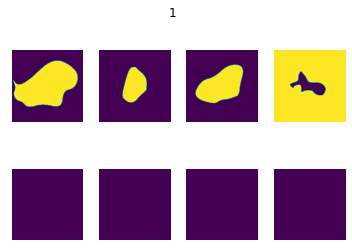

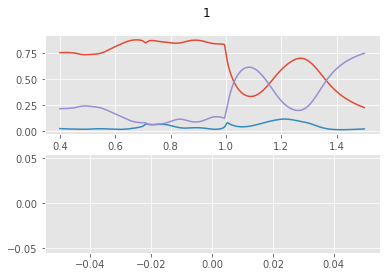

20it [00:05,  3.88it/s]


Train Loss: nan
Val Loss: nan
Epoch 2 of 10


70it [00:23,  2.94it/s]
20it [00:01, 10.65it/s]


Train Loss: nan
Val Loss: nan
Epoch 3 of 10


70it [00:23,  2.94it/s]
20it [00:01, 10.70it/s]


Train Loss: nan
Val Loss: nan
Epoch 4 of 10


70it [00:23,  2.94it/s]
20it [00:01, 10.69it/s]


Train Loss: nan
Val Loss: nan
Epoch 5 of 10


70it [00:23,  2.94it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

MSE loss: tensor(nan, device='cuda:0')


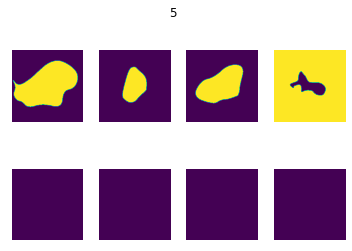

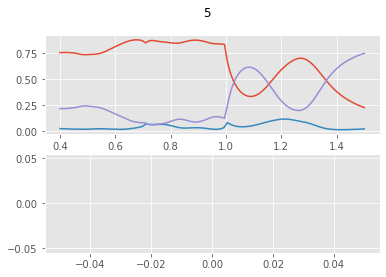

20it [00:03,  5.63it/s]


Train Loss: nan
Val Loss: nan
Epoch 6 of 10


70it [00:23,  2.94it/s]
20it [00:01, 10.71it/s]


Train Loss: nan
Val Loss: nan
Epoch 7 of 10


70it [00:23,  2.94it/s]
20it [00:01, 10.67it/s]


Train Loss: nan
Val Loss: nan
Epoch 8 of 10


70it [00:23,  2.94it/s]
20it [00:01, 10.64it/s]


Train Loss: nan
Val Loss: nan
Epoch 9 of 10


70it [00:23,  2.94it/s]
20it [00:01, 10.64it/s]


Train Loss: nan
Val Loss: nan
Epoch 10 of 10


70it [00:23,  2.94it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

MSE loss: tensor(nan, device='cuda:0')


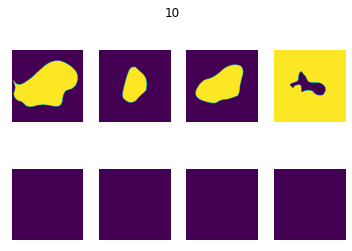

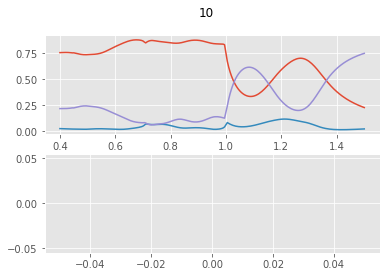

20it [00:03,  5.65it/s]

Train Loss: nan
Val Loss: nan


In [19]:

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    
    train_epoch_loss = fit(model_custom, train_dataloader)
    if epoch == 0 or not ((epoch+1) % 5):
      val_epoch_loss = validate(model_custom, valid_dataloader, 1)
    else:
      val_epoch_loss = validate(model_custom, valid_dataloader, 0)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

In [20]:
!nvidia-smi

Thu Mar 17 01:07:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    51W / 300W |  12665MiB / 16160MiB |     46%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
print(torch.__version__)

1.10.0+cu111
